In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_metric
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

PyTorch version 1.12.0+cu102 available.
2023-06-05 03:16:47.099550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 03:16:47.479876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64:/usr/local/cuda-9.0/lib64:
2023-06-05 03:16:47.479917: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-05 03:16:49.058131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

In [2]:
train_df = pd.read_csv("train/train.En.csv")[["tweet", "sarcastic"]]
train_df["tweet"] = train_df["tweet"].fillna("")
train_df

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
3463,The population spike in Chicago in 9 months is...,0
3464,You'd think in the second to last English clas...,0
3465,I’m finally surfacing after a holiday to Scotl...,0
3466,Couldn't be prouder today. Well done to every ...,0


In [3]:
test_df = pd.read_csv("test/task_A_En_test.csv")
test_df["text"] = test_df["text"].fillna("")
test_df

,text,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men 🥺,0
...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,0
1396,Omg how an earth is that a pen !!! 🤡,0
1397,Bringing Kanye and drake to a tl near you,0
1398,"I love it when women are referred to as ""girl ...",1


In [4]:
def get_train_test_indices(n, test_size):
    n_train = round(n * (1 - test_size))
    all_idxs = list(range(n))
    random.shuffle(all_idxs)
    return all_idxs[:n_train], all_idxs[n_train:]

In [5]:
acc_metric = load_metric("accuracy")
f1_metric = load_metric("f1")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    y_pred = torch.softmax(torch.FloatTensor(predictions), dim=1)[:, 1] > thd
    scores = f1_metric.compute(predictions=y_pred, references=labels)
    scores.update(acc_metric.compute(predictions=y_pred, references=labels))
    return scores

Checking /home/ray080186/.cache/huggingface/datasets/4c530db6524e184f3ae54c23f61ccff4ed3044ff6415e1e28d05618f6eb71752.f7b1a1b5c5768ef71463744e19ab26eb2bfa9b9d2ca9ece6a94ee05f37520247.py for additional imports.
Found main folder for metric https://s3.amazonaws.com/datasets.huggingface.co/datasets/metrics/accuracy/accuracy.py at /home/ray080186/.cache/huggingface/modules/datasets_modules/metrics/accuracy
Found specific version folder for metric https://s3.amazonaws.com/datasets.huggingface.co/datasets/metrics/accuracy/accuracy.py at /home/ray080186/.cache/huggingface/modules/datasets_modules/metrics/accuracy/618004201c82ad7cefba547c6116ab7245ee7ccf428d0b23483d20bcc118fb51
Found script file from https://s3.amazonaws.com/datasets.huggingface.co/datasets/metrics/accuracy/accuracy.py to /home/ray080186/.cache/huggingface/modules/datasets_modules/metrics/accuracy/618004201c82ad7cefba547c6116ab7245ee7ccf428d0b23483d20bcc118fb51/accuracy.py
Couldn't find dataset infos file at https://s3.amazona

In [6]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = "@user" if t.startswith("@") and len(t) > 1 else t
        t = "http" if t.startswith("http") else t
        new_text.append(t)
    return " ".join(new_text)

### Simple baselines
***

#### One predictor

In [7]:
y_test = test_df["sarcastic"].values
y_pred_ones = np.ones(len(y_test))
f1_metric.compute(predictions=y_pred_ones, references=y_test)

Done writing 1400 examples in 11200 bytes /home/ray080186/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.


{'f1': 0.25}

#### TF-IDF + Random Forest Classifier

In [8]:
tfidf = TfidfVectorizer(min_df=2, stop_words="english")
X_train = train_df["tweet"].apply(preprocess).tolist()
X_test = test_df["text"].apply(preprocess).tolist()
tfidf.fit(X_train + X_test)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)
y_train = train_df["sarcastic"].values
X_train.shape, X_test.shape

((3468, 4458), (1400, 4458))

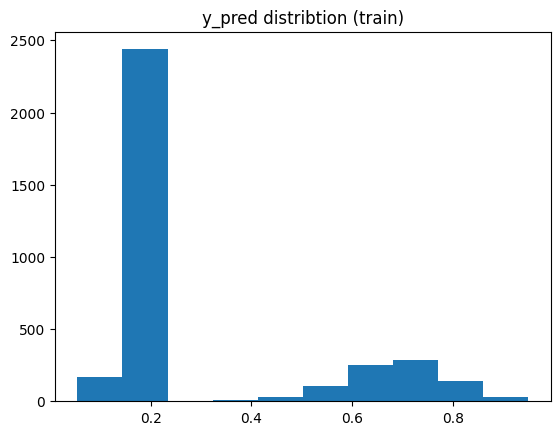

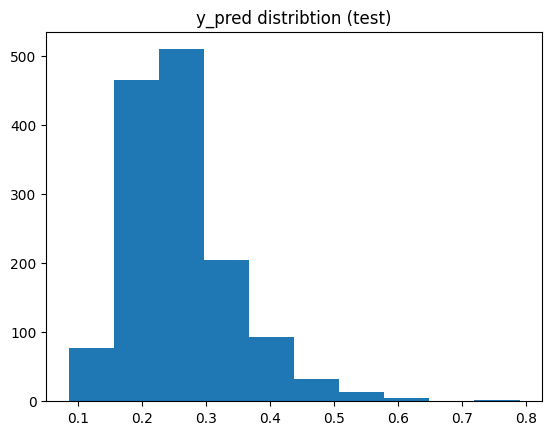

Done writing 3468 examples in 27744 bytes /home/ray080186/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Done writing 1400 examples in 11200 bytes /home/ray080186/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.


Train f1: 0.99
Test f1: 0.302


In [9]:
thd = 0.25
clf = SVC(probability=True, random_state=0)
clf.fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
plt.hist(y_pred_train)
plt.title("y_pred distribtion (train)")
plt.show()
y_pred_test = clf.predict_proba(X_test)[:,1]
plt.title("y_pred distribtion (test)")
plt.hist(y_pred_test)
plt.show()

y_pred_train = y_pred_train > thd
y_pred_test = y_pred_test > thd
train_f1 = f1_metric.compute(predictions=y_pred_train, references=y_train)["f1"]
test_f1 = f1_metric.compute(predictions=y_pred_test, references=y_test)["f1"]
print("Train f1:", round(train_f1, 3))
print("Test f1:", round(test_f1, 3))

### Strong baseline
***

In [10]:
all_idxs = np.arange(len(train_df))
train_idxs, valid_idxs = get_train_test_indices(len(all_idxs), test_size=0.2)
train_idxs, valid_idxs = all_idxs[train_idxs], all_idxs[valid_idxs]
X_train = train_df["tweet"].apply(preprocess).values[train_idxs]
X_valid = train_df["tweet"].apply(preprocess).values[valid_idxs]
X_test = test_df["text"].apply(preprocess).values
y_train = train_df["sarcastic"].values[train_idxs]
y_valid = train_df["sarcastic"].values[valid_idxs]
y_test = test_df["sarcastic"].values

#### Fine-tuned BERT

In [11]:
model_id = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

In [12]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = TweetDataset(train_encodings, y_train)
valid_dataset = TweetDataset(valid_encodings, y_valid)
test_dataset = TweetDataset(test_encodings, y_test)

In [19]:
batch_size = 16
n_epoch = 3
total_steps = round(len(y_train) / batch_size / 4 * n_epoch)
warmup_steps = total_steps * 0.1

training_args = TrainingArguments(
    output_dir="/tmp2/kch/cs263/final_project/models",
    learning_rate=1e-4,
    num_train_epochs=n_epoch,                # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=64,           # batch size for evaluation
    warmup_steps=warmup_steps,               # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                       # strength of weight decay
    logging_dir="./logs",                    # directory for storing logs
    logging_steps=20,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=2,
    ignore_mismatched_sizes=True,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/ray080186/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_t

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.555800,0.606701,0.147368,0.766571
2,0.507400,0.592492,0.341818,0.739193
3,0.220200,0.742100,0.412979,0.713256


***** Running Evaluation *****
  Num examples = 694
  Batch size = 256
Done writing 694 examples in 5552 bytes /home/ray080186/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Done writing 694 examples in 5552 bytes /home/ray080186/.cache/huggingface/metrics/accuracy/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Saving model checkpoint to /tmp2/kch/cs263/final_project/models/checkpoint-44
Configuration saved in /tmp2/kch/cs263/final_project/models/checkpoint-44/config.json
Model weights saved in /tmp2/kch/cs263/final_project/models/checkpoint-44/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 694
  Batch size = 256
Done writing 694 examples in 5552 bytes /home/ray080186/.cache/hug

TrainOutput(global_step=132, training_loss=0.433668132984277, metrics={'train_runtime': 106.4665, 'train_samples_per_second': 78.165, 'train_steps_per_second': 1.24, 'total_flos': 466147484560440.0, 'train_loss': 0.433668132984277, 'epoch': 3.0})

In [22]:
y_pred = trainer.predict(test_dataset)[0]
y_pred = torch.softmax(torch.FloatTensor(y_pred), dim=1)[:, 1] > thd
f1_metric.compute(predictions=y_pred_, references=y_test)

***** Running Prediction *****
  Num examples = 1400
  Batch size = 256
Done writing 1400 examples in 11200 bytes /home/ray080186/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Done writing 1400 examples in 11200 bytes /home/ray080186/.cache/huggingface/metrics/accuracy/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Done writing 1400 examples in 11200 bytes /home/ray080186/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.


{'f1': 0.33087149187592324}

In [16]:
# for error analysis
y_pred = trainer.predict(valid_dataset)[0]
y_pred = torch.softmax(torch.FloatTensor(y_pred), dim=1)[:, 1] > thd

valid_df = train_df.iloc[valid_idxs].copy()
valid_df["pred"] = y_pred.int().tolist()
valid_df[["tweet", "sarcastic", "pred"]].to_csv(
    "predictions/valid_pred_df.csv", index=False
)

***** Running Prediction *****
  Num examples = 694
  Batch size = 256
Done writing 694 examples in 5552 bytes /home/ray080186/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.
Done writing 694 examples in 5552 bytes /home/ray080186/.cache/huggingface/metrics/accuracy/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.


### Super strong baseline
#### ChatGPT

In [17]:
n_sample = 100
random.seed(0)
sample_idxs = random.sample(range(len(y_test)), n_sample)
X_test_sample = X_test[sample_idxs]
y_test_sample = y_test[sample_idxs]

X_test_sample_str = [f"{i+1}. {s}" for i, s in enumerate(X_test_sample)]
X_test_sample_str = "\n".join(X_test_sample_str)

prompt = f"""
Predict if the following 100 tweets are sarcastic.
Return 0 or 1 for each tweet.
{X_test_sample_str}
"""
print(prompt)


Predict if the following 100 tweets are sarcastic.
Return 0 or 1 for each tweet.
1. The usual UK race baiters, strangely have got absolutely nothing to say about the Jussie Smollett case.
2. “You’re English right?”
“Yeah, big time”
3. Well the tax payer was the loser
4. They been ON US since the layover lol
5. You must have a certain level of bothered… to attend the gym with a full face of make up???
6. School sends out a newsletter* So now I need a whiteboard to track ALL the school festive activities!! Mufti day - don’t forget to make a payment for this, carol concert, early school closure etc Does it ever stop! 
7. So school have sent out a really helpful newsletter with all key dates and activities. So many fun things arranged for the children.
8. my darling my dear my darling
9. game 1 of playoffs last season… take away the JT injury &amp; the loss
10. Chloe's body is amazing though. She just be doing weird stuff sometimes.
11. My boss is so immature. It frustrates me that she is

In [18]:
chatgpt_output = """
1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
0
0
1
0
0
0
0
0
1
1
0
1
1
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
"""
y_pred_chatgpt = [int(s[0]) for s in chatgpt_output.split("\n")[1:-1]]
f1_metric.compute(predictions=y_pred_chatgpt, references=y_test_sample)

Done writing 100 examples in 800 bytes /home/ray080186/.cache/huggingface/metrics/f1/default/default_experiment-1-0.arrow.
Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formatted) columns.


{'f1': 0.3684210526315789}